In [1]:
import pykalman

import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle,itertools
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import data_prep_new as dpn
import preprocess as prep
import animate_helper as ah
np.set_printoptions(precision=3,suppress=True)

import place_field_analysis as pf

In [2]:
%matplotlib inline

In [3]:
# data_dir_full=db.query('owner=="roman"')['data_dir_full'][2]
# data_dir_full
db.query('owner=="ipshita"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
IZ33        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            2  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            3  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
            1  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   
IZ32        0  /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/...   

                              sess_name animal_name.1        date  \
animal_name                                                         
IZ33        0   IZ33_580um_210312_sess8          IZ33  2021-03-12   
            2  IZ33_580um_210317_sess10          IZ33  2021-03-17   
            3  IZ33_580um_210319_sess11          IZ33  2021-03-19   
            1   IZ33_580um_210315_sess9          IZ33  2021-03-15   
IZ32        0  IZ32_1008um_210303_sess7          IZ32  2021-03-03   

                                    behavior  performance  ntrials  \
animal_name                                                          
IZ33        0  ['alternation' 'alternation']     0.841463       82   
            2  ['alternation' 'alternation']     0.804878       82   
            3  ['alternation' 'alternation']     0.795181       83   
            1  ['alternation' 'alternation']     0.829268       82   
IZ32        0  ['alternation' 'alternation']     0.833333      102   

               ngoodtrials  n_neurons  n_pyr_putative    owner     data_root  
animal_name                                                                   
IZ33        0           82        180             120  ipshita  ipshita_data  
            2           82        169             106  ipshita  ipshita_data  
            3           83        152              95  ipshita  ipshita_data  
            1           82        143              77  ipshita  ipshita_data  
IZ32        0          102         89              76  ipshita  ipshita_data

In [2]:
data_dir_full = db.query('owner=="ipshita"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [5]:
data_dir_full

'/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8'

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="ipshita"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={'sessionPulses':'*SessionPulses.Events.mat'},
                               load_type='ipshita'
                              )
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']





/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/spk_beh_df.p saved!


In [232]:
region_d = {1:'contra',2:'ipsi',3:'both'}
target_d = {1:'center',2:'return'}

for k,val in sessionPulses.items():
    print(region_d[val['region']])
    print(target_d[val['target']])

ipsi
center
both
center


In [4]:
import place_field_analysis as pf

In [163]:
reload(pf)
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=True,bin_size = 2.2, 
                                        save_fn = 'place_field_avg_and_trial_speed_kalmanthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_speed_kalmanthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='speed_kalman',load_only=False
                                        )

/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/fr_map_null_trialtype_speed_kalmanthresh.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:371: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:371: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:371: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:371: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


saved at /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/place_field_avg_and_trial_speed_kalmanthresh.p


67 sessions!
/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/place_field_avg_and_trial_speed_kalmanthresh.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main p

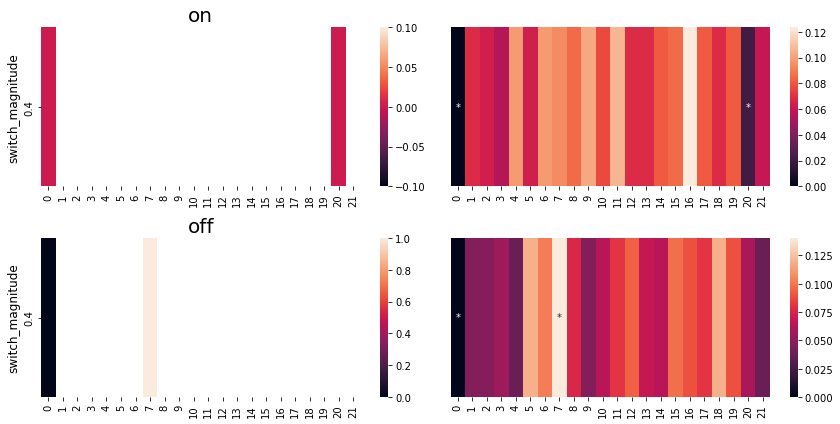

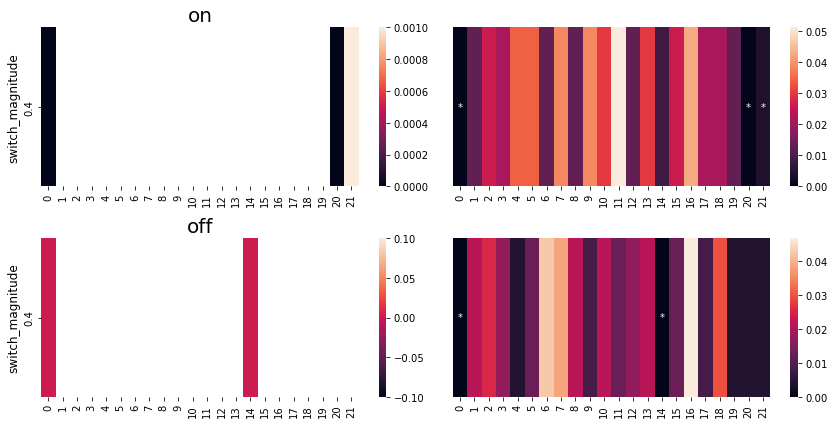

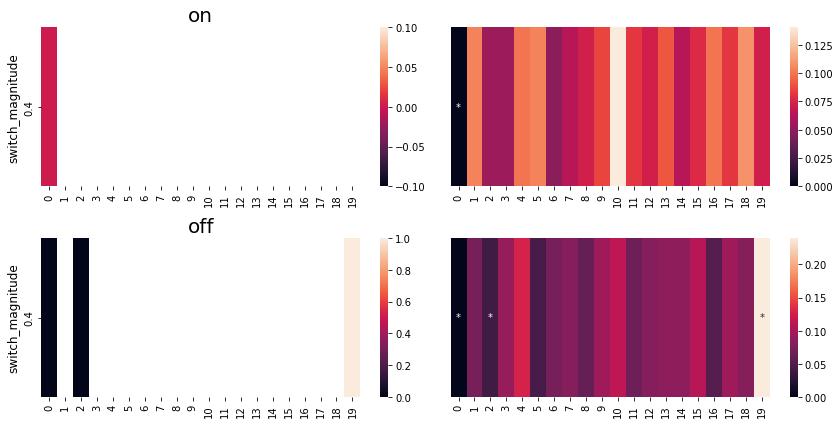

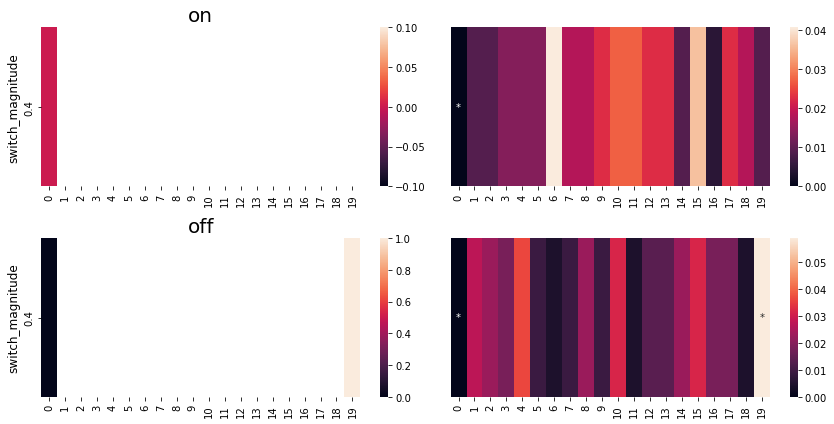

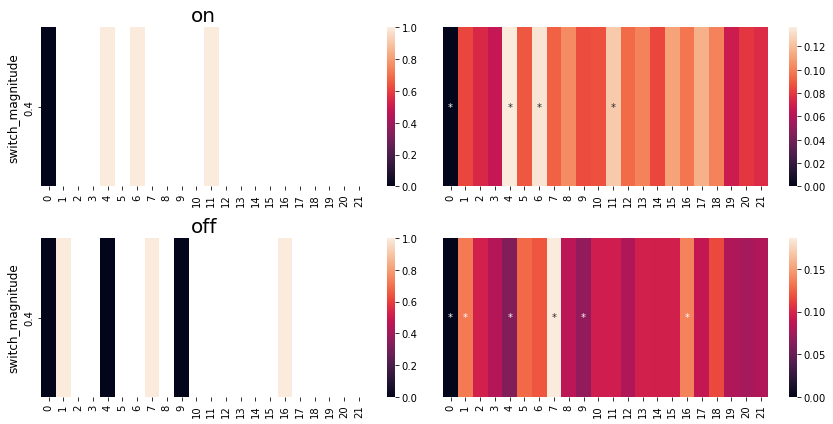

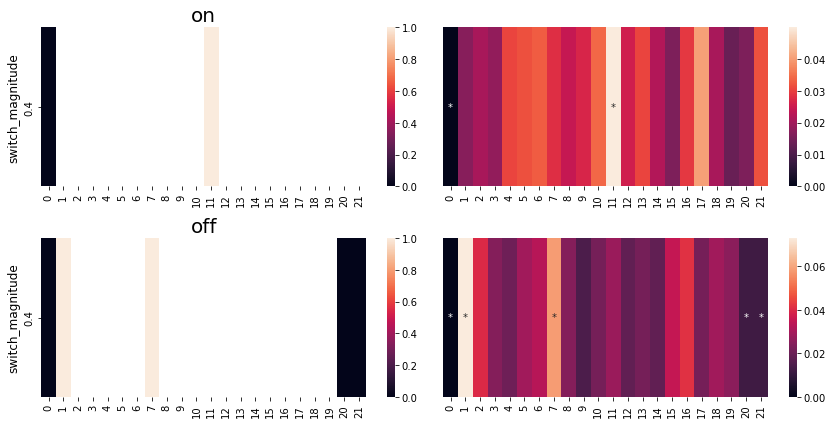

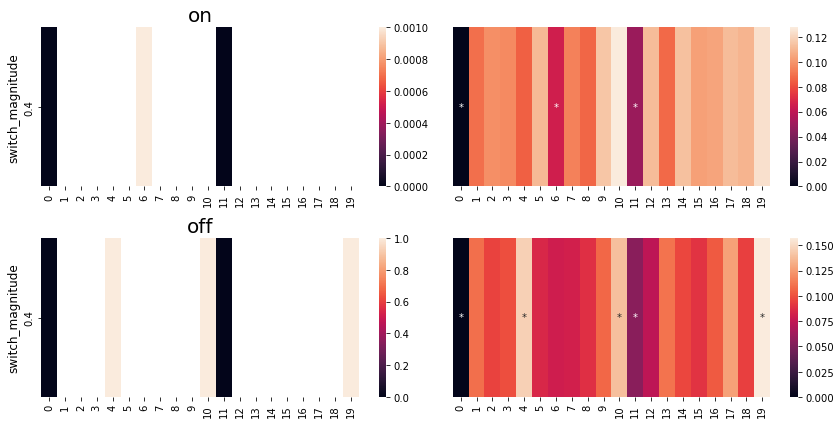

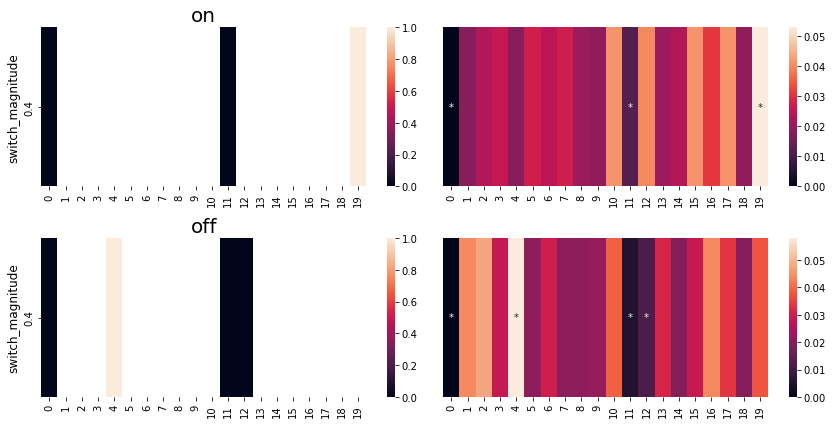

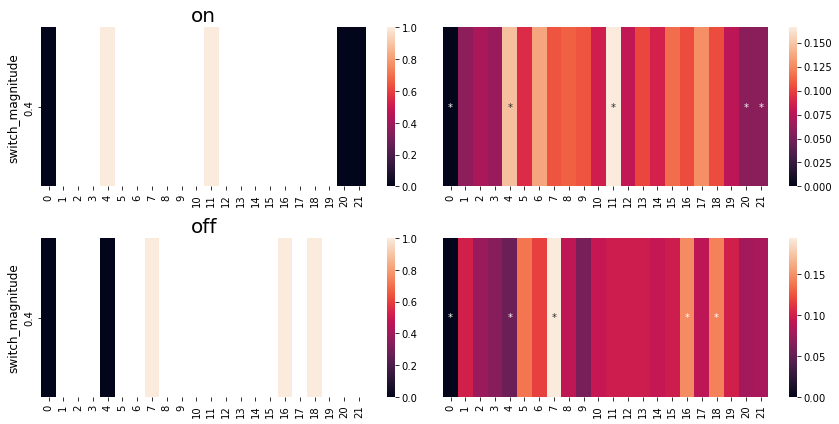

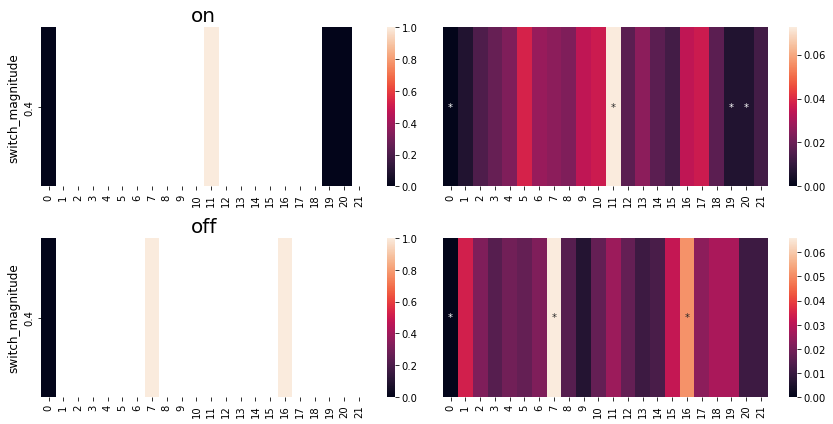

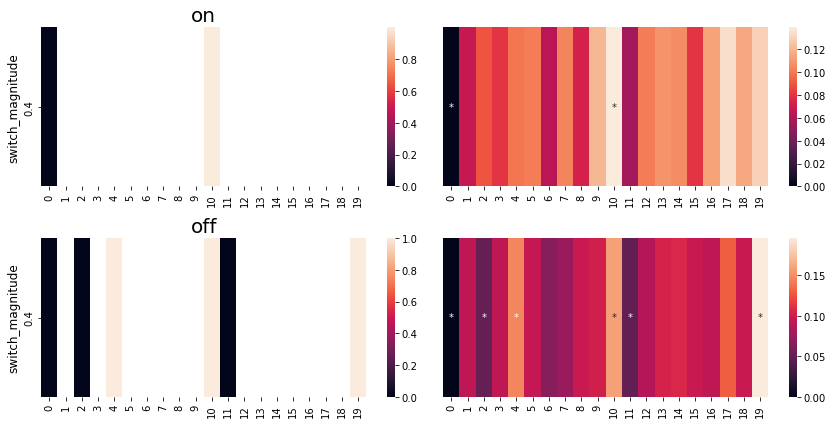

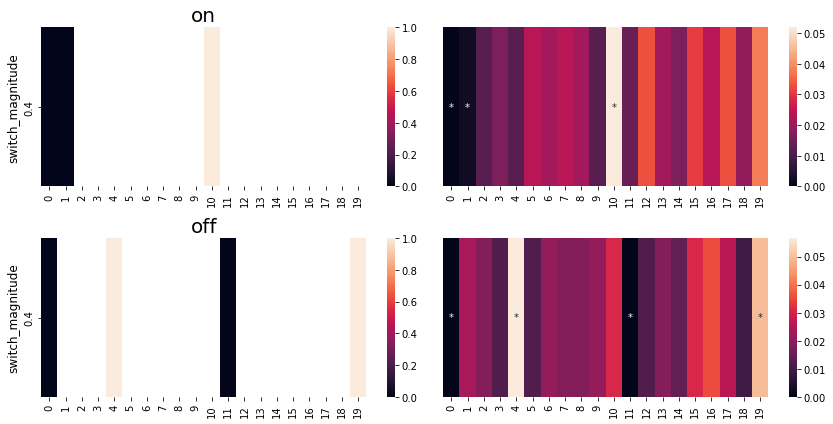

In [234]:
%%time
import switch_analysis_one_session as saos
reload(saos)
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              place_field_fn = 'place_field_avg_and_trial_speed_kalmanthresh.p', 
                                                shuffle_fn='fr_map_null_trialtype_speed_kalmanthresh.p',
                                              save_fn='shuffle_detection_speedkalmanthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p',
                                              load_only=False)

In [235]:
import change_point_analysis_central_arm_seperate as cpacas

/tmp/ipykernel_1807712/32635965.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3].dropna(axis=1)


0   1   2   3   4   5   6   7   8   9   10  11  \
switch_magnitude 0.4 1   1   0  -1   0   0   0   0   0   0   0   0   0   0   
                     2   0   0   0   0   0   0   0   0   0   0   0   0   0   
                         1   0   0   0   1   0   0   0   0   0   0  -1   0   
                         2   0   0   0   0   0   0   0   0   0   0   0   0   
                     3   0   0   0   0   0   0   0   0   0   0   1   0   0   
...                         ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
                     176 0   0   0   0   0   0   0   0   0   0   0   0   0   
                         1   0   0   0   0   0   0   0   0   0   0   0   0   
                     177 0   0   0   0   0   0   0   0   0   0   0   0   0   
                     178 0   0   0   0   0   0   0   0   0   0   0   0   0   
                     180 2   0   0   0   0   0   0   0   0   0   0   0   0   

                            12  13  14  15  16  17  18  19  
switch_magnitude 0.4 1   1   0   0   0   0   0   0   0   0  
                     2   0   0   0   0   1   0  -1   0   0  
                         1   0   0   0   0   0   0   0   0  
                         2   0   0   0   1   0   0   0   0  
                     3   0   0   0   0   0   0   0   0   0  
...                         ..  ..  ..  ..  ..  ..  ..  ..  
                     176 0   0   0   0   0   0   0   0   0  
                         1   0   0   0   1   0   0   0   0  
                     177 0   0   0   0   0   0   0   0   0  
                     178 0   0   0   0   0  -1   0   0   0  
                     180 2   0   0   0   0   0   0   0   0  

[221 rows x 20 columns]

In [9]:
# def get_cell_cols_d_with_brainregion(cell_metrics):
#     '''
#     get cell_cols_d, keys: (brain_region, cell_type), cell_type: 'pyr' pr 'int'
#     '''
#     region_mask={}
#     cell_type_possible = ['pyr','int']
#     cell_cols_d = {}
#     for br,ct in itertools.product(np.unique(cell_metrics['brainRegion']),cell_type_possible):
#         region_mask = cell_metrics['brainRegion']==br
#         ct_mask = np.array([ct in s.lower() for s in cell_metrics['putativeCellType']])
#         cell_cols_d[br,ct] = cell_metrics['UID'][region_mask & ct_mask]
#     return cell_cols_d

# def add_stim(spk_beh_df,sessionPulses,stim_key='stim'):
#     stim_l = []
#     for key, val in sessionPulses.items():
#         stim_l.append(val[stim_key])
#     spk_beh_df = dpp.add_trial_specific_info(spk_beh_df,stim_key,stim_l)
#     return spk_beh_df

In [11]:
# spk_beh_df = dpp.add_trial_specific_info(spk_beh_df,'stim',stim_l)
# spk_beh_df =add_stim(spk_beh_df,sessionPulses,stim_key='stim')

In [7]:
reload(pa)
cell_cols = np.concatenate(list(cell_cols_d.values()))
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],bin_size=2.2,speed_key='speed_kalman')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [8]:
fr_peak=pf_res['avg']['params'][0,0].loc['fr_peak']

In [9]:
pf_res['avg']['all_fields'][0,0]

start end com peak    fr_peak    fr_mean
    field_index                                         
1   0              35  41  37   38   5.504545   5.154941
    1              63  68  65   66   5.665247   5.325145
2   0              27  39  32   32   9.474199   6.484027
6   0              65  72  68   68   2.198267   1.895744
9   0               8  13  10   10   2.271957   1.901141
...               ...  ..  ..  ...        ...        ...
176 1              63  76  69   70   1.439334   1.133487
177 1              64  76  70   76   5.201754   3.918794
178 1              52  64  57   55   2.529855   2.254504
180 0              53  58  55   55   19.77214  18.690538
    1              66  76  71   76  19.015955  18.259816

[94 rows x 6 columns]

<AxesSubplot:>

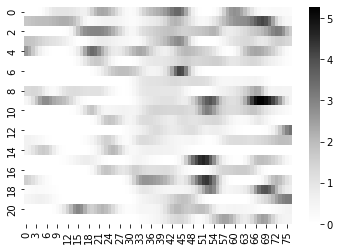

In [11]:
%matplotlib inline
uid=6
sns.heatmap(fr_map_trial_df_d.loc[0,0].loc[uid].T,cmap='Greys')

In [68]:
fr_map_null = pf.get_fr_map_shuffle_wrapper(data_dir_full,nrepeats=1000, dosave=True,force_reload=False,bin_size=2.2, save_fn='fr_map_null_trialtype_speed_kalmanthresh.p',speed_key='speed_kalman')



/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/fr_map_null_trialtype_speed_kalmanthresh.p exists; loading---


In [22]:
trial_avg_info = spk_beh_df.groupby(['task_index','trial']).mean()

In [34]:
task_ind =0
tt_ind = 0
trial_avg_info_one_task =trial_avg_info.loc[task_ind]
stim_trial_one_tt = trial_avg_info_one_task.loc[trial_avg_info_one_task['visitedArm']==tt_ind,'stim_trial']

In [298]:
changes_df=switch_res['avg']['changes_df'].loc[0,slice(None),0.3,'switch_magnitude',0.4]

In [301]:
trial_avg_info_one_task

1         2         3         4         5         6         7  \
trial                                                                         
0      0.102464  0.108949  0.018158  1.324254  0.042802  0.041505  0.015564   
1      0.117216  0.053114  0.009158  1.078755  0.036630  0.062271  0.007326   
2      0.191250  0.040625  0.001875  1.025625  0.026250  0.046875  0.040000   
3      0.083082  0.091511  0.010235  1.107766  0.068031  0.060807  0.030102   
4      0.085225  0.080593  0.008800  1.017138  0.083835  0.031496  0.052339   
5      0.102592  0.086045  0.005516  1.023718  0.026475  0.042471  0.026475   
6      0.178459  0.078616  0.018868  0.930031  0.036950  0.047170  0.018082   
7      0.107186  0.071255  0.010353  1.009744  0.038977  0.034714  0.054202   
8      0.163393  0.053571  0.010714  0.962500  0.057143  0.036607  0.068750   
9      0.116471  0.131765  0.008235  0.854118  0.029412  0.029412  0.037647   
10     0.048822  0.062290  0.005051  0.856902  0.026936  0.058923  0.067340   
11     0.196909  0.082661  0.009409  1.112231  0.026882  0.053763  0.067204   
12     0.174613  0.039948  0.019974  0.975515  0.054124  0.019974  0.041881   
13     0.111389  0.090113  0.012516  1.115144  0.051940  0.022528  0.075094   
14     0.162646  0.055824  0.038594  1.015851  0.023432  0.029635  0.053067   
15     0.110741  0.085762  0.027477  1.029975  0.095754  0.022481  0.091590   
16     0.113620  0.099506  0.030346  1.135498  0.024700  0.076923  0.053634   
17     0.152405  0.071899  0.026835  1.022785  0.080506  0.037468  0.132658   
18     0.168439  0.110241  0.026861  1.054841  0.024622  0.039172  0.017907   
19     0.107661  0.111668  0.040060  1.039059  0.048573  0.023035  0.107661   
20     0.118664  0.065668  0.036866  1.087558  0.066820  0.086406  0.101382   
21     0.131062  0.169069  0.082569  0.958060  0.049803  0.026212  0.020970   
22     0.080132  0.068212  0.059603  1.005298  0.046358  0.031126  0.042384   
23     0.115366  0.138930  0.099656  0.976436  0.031419  0.027000  0.018164   
24     0.051240  0.075207  0.058678  0.938017  0.028099  0.016529  0.102479   
25     0.141339  0.108927  0.126461  1.011690  0.007970  0.035600  0.018597   
26     0.199700  0.060060  0.098348  0.993994  0.041291  0.024024  0.040541   
27     0.149750  0.126456  0.101498  0.981697  0.034942  0.011647  0.028286   
28     0.045012  0.040146  0.055961  1.045012  0.043796  0.007299  0.121655   
29     0.101395  0.080000  0.079070  1.022326  0.022326  0.029767  0.007442   
30     0.120249  0.105045  0.071873  1.118176  0.035245  0.087768  0.116102   
31     0.099834  0.071547  0.133111  0.876872  0.019967  0.034942  0.014975   
32     0.115982  0.067580  0.107763  0.965297  0.067275  0.035921  0.113851   
33     0.171698  0.101887  0.101887  1.037736  0.024528  0.058491  0.018868   
34     0.083593  0.158453  0.114785  0.885215  0.063631  0.062383  0.081722   
35     0.136297  0.070700  0.140671  0.817784  0.014577  0.030612  0.010204   
36     0.069016  0.104258  0.067548  1.051395  0.080764  0.020558  0.049927   
37     0.089251  0.092131  0.091171  0.966411  0.002879  0.038388  0.002879   
38     0.096618  0.081320  0.122383  0.943639  0.044283  0.036232  0.037037   
39     0.088919  0.088919  0.138167  1.013680  0.013680  0.023256  0.025992   
40     0.132723  0.084668  0.104500  0.915332  0.012204  0.022883  0.031274   
41     0.047354  0.100279  0.072423  1.086351  0.072423  0.013928  0.033426   

              8         9        10  ...       180         lin          x  \
trial                                ...                                    
0      0.533074  0.019455  0.138781  ...  0.636835  103.913474  31.076712   
1      0.739927  0.113553  0.141026  ...  0.663004   90.773957  29.116105   
2      0.708125  0.030625  0.183125  ...  0.648125  107.743549  29.508291   
3      0.675497  0.016255  0.114389  ...  0.638170  109.240782  30.254312   
4      0.674386  0.031496  0.115331  ...  0.610931   87.402515  21.775099  

In [302]:
stim_trial_both_tt = {}
for tt_ind in trial_avg_info_one_task['visitedArm'].unique():
    stim_trial_one_tt = trial_avg_info_one_task.loc[trial_avg_info_one_task['visitedArm']==tt_ind,'stim_trial']
    stim_trial_both_tt[tt_ind] = stim_trial_one_tt
stim_trial_both_tt

{0.0: trial
 0     0.0
 1     0.0
 3     0.0
 5     0.0
 6     0.0
 8     0.0
 9     0.0
 12    1.0
 14    1.0
 16    1.0
 18    1.0
 21    0.0
 23    0.0
 25    0.0
 27    0.0
 29    0.0
 31    1.0
 33    1.0
 35    1.0
 37    1.0
 39    1.0
 40    0.0
 Name: stim_trial, dtype: float64,
 1.0: trial
 2     0.0
 4     0.0
 7     0.0
 10    1.0
 11    1.0
 13    1.0
 15    1.0
 17    1.0
 19    1.0
 20    0.0
 22    0.0
 24    0.0
 26    0.0
 28    0.0
 30    1.0
 32    1.0
 34    1.0
 36    1.0
 38    1.0
 41    0.0
 Name: stim_trial, dtype: float64}

on  stim
0   0.0   0.0
1   2.0   0.0
2   2.0   0.0
3   3.0   1.0
4   3.0   1.0
5   3.0   1.0
6   9.0   1.0
7   4.0   1.0
8   4.0   1.0
9   5.0   0.0
10  6.0   0.0
11  6.0   0.0
12  5.0   0.0
13  5.0   0.0
14  2.0   1.0
15  8.0   1.0
16  1.0   1.0
17  5.0   1.0
18  4.0   1.0
19  2.0   0.0

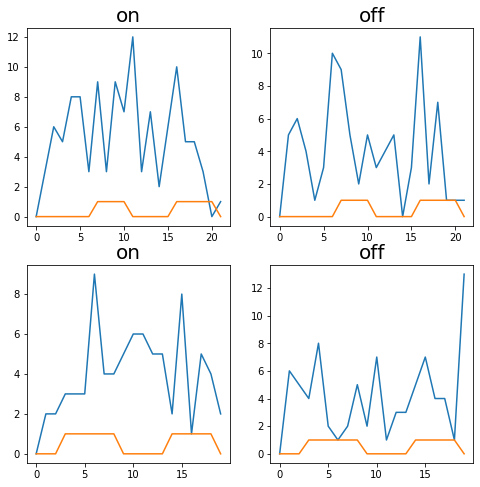

In [318]:
tt_l = [0,1]
fig,axs=plt.subplots(2,2,figsize=(8,8))
for ii,tt_ind in enumerate(tt_l):
    ch = changes_df.loc[tt_ind].dropna(axis=1)
    ons=(ch==1).sum(axis=0)
    offs=(ch==-1).sum(axis=0)
    
    stim = stim_trial_both_tt[tt_ind].values
    onoff_stim = pd.DataFrame([ons.values,stim],columns=ons.index,index=['on','stim']).T
    onoff_stim['off'] = offs
    
    ax=ons.plot(ax=axs[ii,0])
    ax.plot(stim_trial_both_tt[tt_ind].values)
    ax.set_title('on')

    ax=offs.plot(ax=axs[ii,1])
    ax.plot(stim_trial_both_tt[tt_ind].values)
    ax.set_title('off')
    


In [321]:
onoff_stim.groupby('stim').sum()

on  off
stim           
0.0   33.0   40
1.0   46.0   43

In [309]:
ons

0     0
1     2
2     2
3     3
4     3
5     3
6     9
7     4
8     4
9     5
10    6
11    6
12    5
13    5
14    2
15    8
16    1
17    5
18    4
19    2
dtype: int64

In [304]:
ons

1    1    0
2    0    1
     1    1
     2    1
3    0    1
         ..
176  0    0
     1    1
177  0    0
178  0    0
180  2    0
Length: 221, dtype: int64

In [295]:
(changes_df==1).sum(axis=0)

0      0
1      3
2      6
3      5
4      8
5      8
6      3
7      9
8      3
9      9
10     7
11    12
12     3
13     7
14     2
15     6
16    10
17     5
18     5
19     3
20     0
21     1
dtype: int64

In [296]:
stim_trial_one_tt.values==stim

array([False, False, False, False, False, False, False,  True,  True,
        True,  True, False, False, False, False, False,  True,  True,
        True,  True,  True, False])

In [297]:
stim_trial_one_tt

trial
0     0.0
1     0.0
3     0.0
5     0.0
6     0.0
8     0.0
9     0.0
12    1.0
14    1.0
16    1.0
18    1.0
21    0.0
23    0.0
25    0.0
27    0.0
29    0.0
31    1.0
33    1.0
35    1.0
37    1.0
39    1.0
40    0.0
Name: stim_trial, dtype: float64

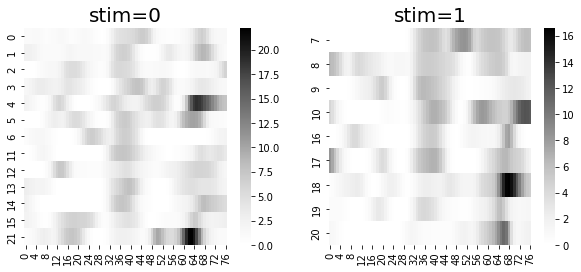

In [245]:
uid=1
tt_ind=0
fig,axs=plt.subplots(1,2,figsize=(10,4))
for ii,stim in enumerate([0,1]):
    sns.heatmap(fr_map_trial_df_d.loc[task_ind,tt_ind].loc[uid].T.loc[stim_trial_one_tt.values==stim],cmap='Greys',ax=axs[ii])
    axs[ii].set_title(f'stim={stim}')


In [15]:
spk_beh_df.groupby(['task_index','visitedArm','stim_trial'])['trial'].unique()

task_index  visitedArm  stim_trial
0           0.0         0.0           [0, 1, 3, 5, 6, 8, 9, 21, 23, 25, 27, 29, 40]
                        1.0                    [12, 14, 16, 18, 31, 33, 35, 37, 39]
            1.0         0.0                       [2, 4, 7, 20, 22, 24, 26, 28, 41]
                        1.0            [10, 11, 13, 15, 17, 19, 30, 32, 34, 36, 38]
1           0.0         0.0                 [0, 2, 4, 6, 8, 20, 23, 25, 27, 40, 41]
                        1.0            [10, 12, 15, 17, 18, 30, 32, 34, 35, 37, 38]
            1.0         0.0                 [1, 3, 5, 7, 9, 21, 22, 24, 26, 28, 29]
                        1.0                    [11, 13, 14, 16, 19, 31, 33, 36, 39]
Name: trial, dtype: object

In [16]:
spk_beh_df.groupby(['task_index','visitedArm'])['trial'].unique()

task_index  visitedArm
0           0.0           [0, 1, 3, 5, 6, 8, 9, 12, 14, 16, 18, 21, 23, ...
            1.0           [2, 4, 7, 10, 11, 13, 15, 17, 19, 20, 22, 24, ...
1           0.0           [0, 2, 4, 6, 8, 10, 12, 15, 17, 18, 20, 23, 25...
            1.0           [1, 3, 5, 7, 9, 11, 13, 14, 16, 19, 21, 22, 24...
Name: trial, dtype: object

In [6]:
spk_beh_df_onetask = spk_beh_df.query('task_index==0')
fr_map_trial_all,_,_=pa.get_fr_map_trial_onegroup(spk_beh_df_onetask,cell_cols,gauss_width=2.5,order=['smooth','divide'],n_lin_bins=nbins,speed_key='speed')

fr_map_trial_all_df = pf.fr_map_trial_to_df(fr_map_trial_all,cell_cols)


cant format into a dataframe


# vector bundle PCA

In [7]:
import pca_analysis as pcaa
reload(pcaa)

<module 'pca_analysis' from '/mnt/home/szheng/projects/nmf_analysis/pca_analysis.py'>

In [8]:
task_ind,tt_ind = 0,1
fr_map_trial = fr_map_trial_d[task_ind,tt_ind]#fr_map_trial_all#
reload(pcaa)
fr_map_trial_centered_normed_df,fr_map_trial_centered_normed = pcaa.preprocess_fr_map_trial(fr_map_trial,cell_cols)
X_l=pcaa.prep_X_l(fr_map_trial_centered_normed)

In [269]:
X_l.shape

(77, 100, 20)

In [9]:
%%time
#high lam
reload(pcaa)
w_l_allfac_fit_highlam, h_l_allfac_fit_highlam,l_all_allfac, l_recon_allfac, l_reg_allfac,w_l_allfac, h_l_allfac,r2_allfac, r2_pos_allfac  = \
    pcaa.train_all_factor(X_l,n_fac=5,lam=20.,max_iters = 800, stop_thresh = 0.00001,
                    fr_map_trial_centered_normed_df=fr_map_trial_centered_normed_df,w_l_allfac=None,h_l_allfac=None,
                    pos_mask = None,return_init=True)

CPU times: user 19.2 s, sys: 11.8 s, total: 31 s
Wall time: 8.13 s


In [10]:
import vbpca_plot as vp
reload(vp)

<module 'vbpca_plot' from '/mnt/home/szheng/projects/nmf_analysis/vbpca_plot.py'>

In [271]:
len(l_recon_allfac[1])

463

In [141]:
# w_l_allfac_fit_highlam, h_l_allfac_fit_highlam
# for i in range()
# resid = pcaa.get_resid(X_l,w_l,h_l)
# get_var_explained_ratio(X_l,w_l,h_l,pos_mask=None)

<IPython.core.display.Javascript object>


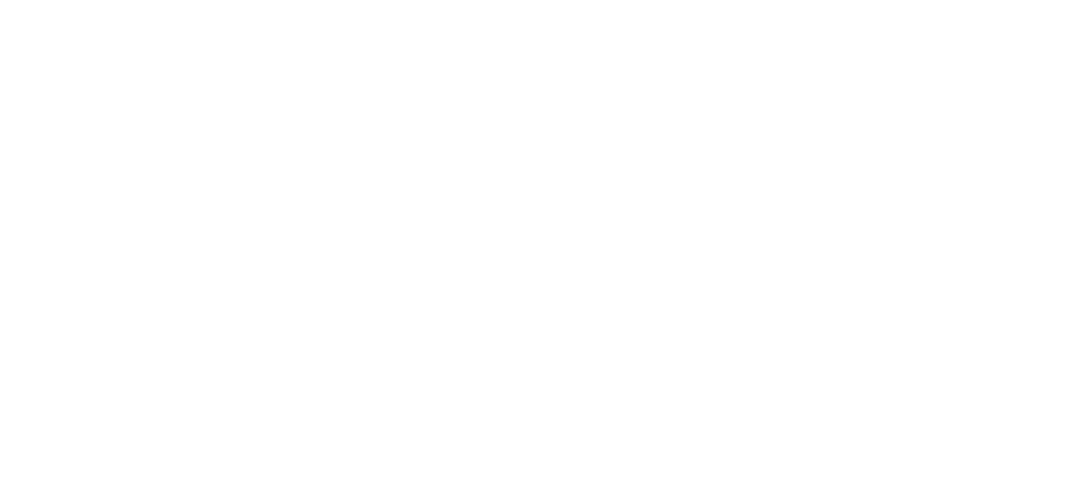

(<Figure size 1800x800 with 11 Axes>,
 <AxesSubplot:title={'center':'factor 4 loss r2 = 0.06'}>)

In [272]:
%matplotlib notebook
vp.plot_loss(l_all_allfac,l_recon_allfac,r2_allfac)

In [273]:
r2_allfac[:5].sum()

0.5855175714316937

<IPython.core.display.Javascript object>


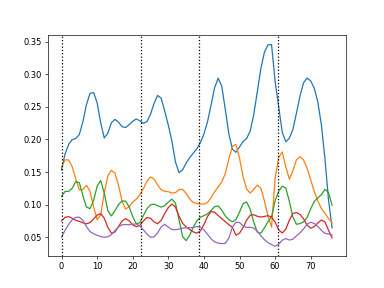

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

In [274]:
reload(ph)
%matplotlib notebook
fig,ax=plt.subplots()
ax.plot(r2_pos_allfac[:10].T)
ph.plot_vlines(lin_val_left/binsize_in_lin,ax=ax,fig=fig)

In [11]:
# trial_ind_l=spk_beh_df_onetask['trial'].unique()
trial_ind_l=spk_beh_df_onetask.query('visitedArm==@tt_ind')['trial'].unique()

stim_per_trial = spk_beh_df_onetask.groupby('trial')['stim'].unique().apply(lambda x:x[0])
visitedArm_per_trial = spk_beh_df_onetask.groupby('trial')['visitedArm'].unique().apply(lambda x:x[0])
random_per_trial = pd.Series(np.random.randint(2,size=stim_per_trial.shape[0]))

h_l_allfac_fit_df = pcaa.post_process_loadings(h_l_allfac_fit_highlam,trial_ind_l=trial_ind_l)
h_l_allfac_fit_df['stim'] = stim_per_trial.loc[h_l_allfac_fit_df['trial'].values].values
h_l_allfac_fit_df['visitedArm'] = visitedArm_per_trial.loc[h_l_allfac_fit_df['trial'].values].values
h_l_allfac_fit_df['random'] = random_per_trial.loc[h_l_allfac_fit_df['trial'].values].values

trial_l = np.arange(h_l_allfac_fit_highlam.shape[-1])
color_l = ah.map_colors(trial_l,npos=None,cmap_name='vlag')
color_l_series = pd.Series(color_l,index=trial_ind_l)

stim_per_trial_actual = stim_per_trial.loc[trial_ind_l]
linestyle_l = ['-.' if i else '-' for i in stim_per_trial_actual] 

<IPython.core.display.Javascript object>


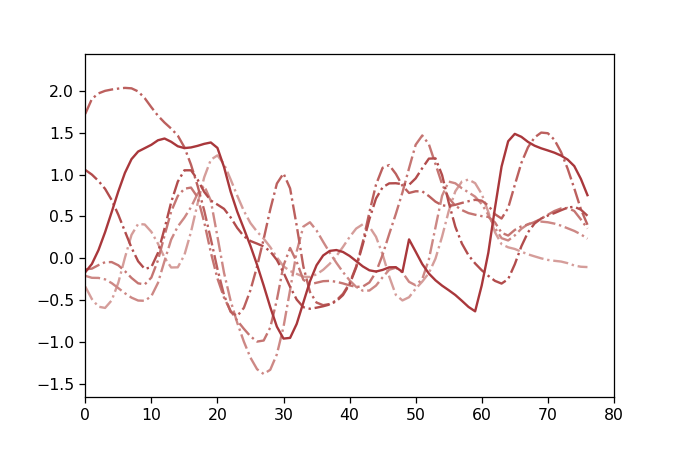

In [16]:
%matplotlib notebook
eig_ind = 0

save_kws=dict(
    root = data_dir_full,
    sub_dir = 'vbpca',
    name=f'pc{eig_ind}_vs_pos_lam20',
    fps=5
)


data = h_l_allfac_fit_highlam[:,eig_ind,:]
data = np.concatenate([np.arange(data.shape[0])[:,None],data],axis=1)

reload(ah)
lin_bin_range = (0,80)
fig,ax,ani=ah.animate_line_morph(data,legend_handles=None,color_l=color_l,linestyle_l=linestyle_l,max_length=5,fig=None,ax=None,ax_kws={'xlim':lin_bin_range},animate_kws={'interval':1000},dosave=False,save_kws=save_kws)




In [35]:
stim_per_trial_actual

trial
2     0.0
4     0.0
7     0.0
10    1.0
11    1.0
13    1.0
15    1.0
17    1.0
19    1.0
20    0.0
22    0.0
24    0.0
26    0.0
28    0.0
30    1.0
32    1.0
34    1.0
36    1.0
38    1.0
41    0.0
Name: stim, dtype: float64

<IPython.core.display.Javascript object>


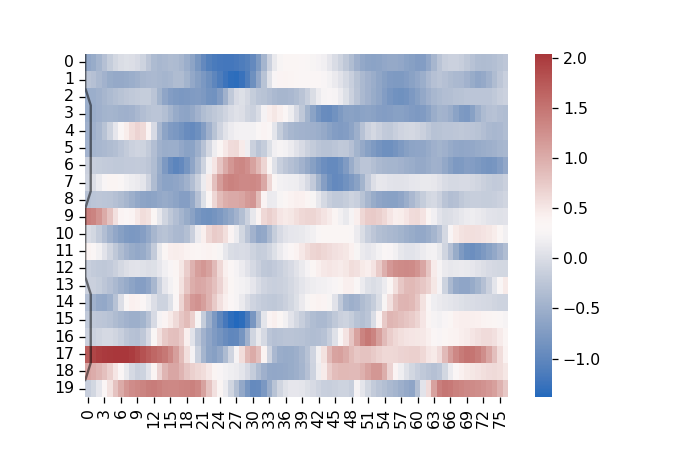

In [37]:
ax=sns.heatmap(h_l_allfac_fit_highlam[:,0,:].T,cmap='vlag')
ax.plot(stim_per_trial_actual.values,np.arange(len(stim_per_trial_actual)),c='k',alpha=0.5)

<IPython.core.display.Javascript object>


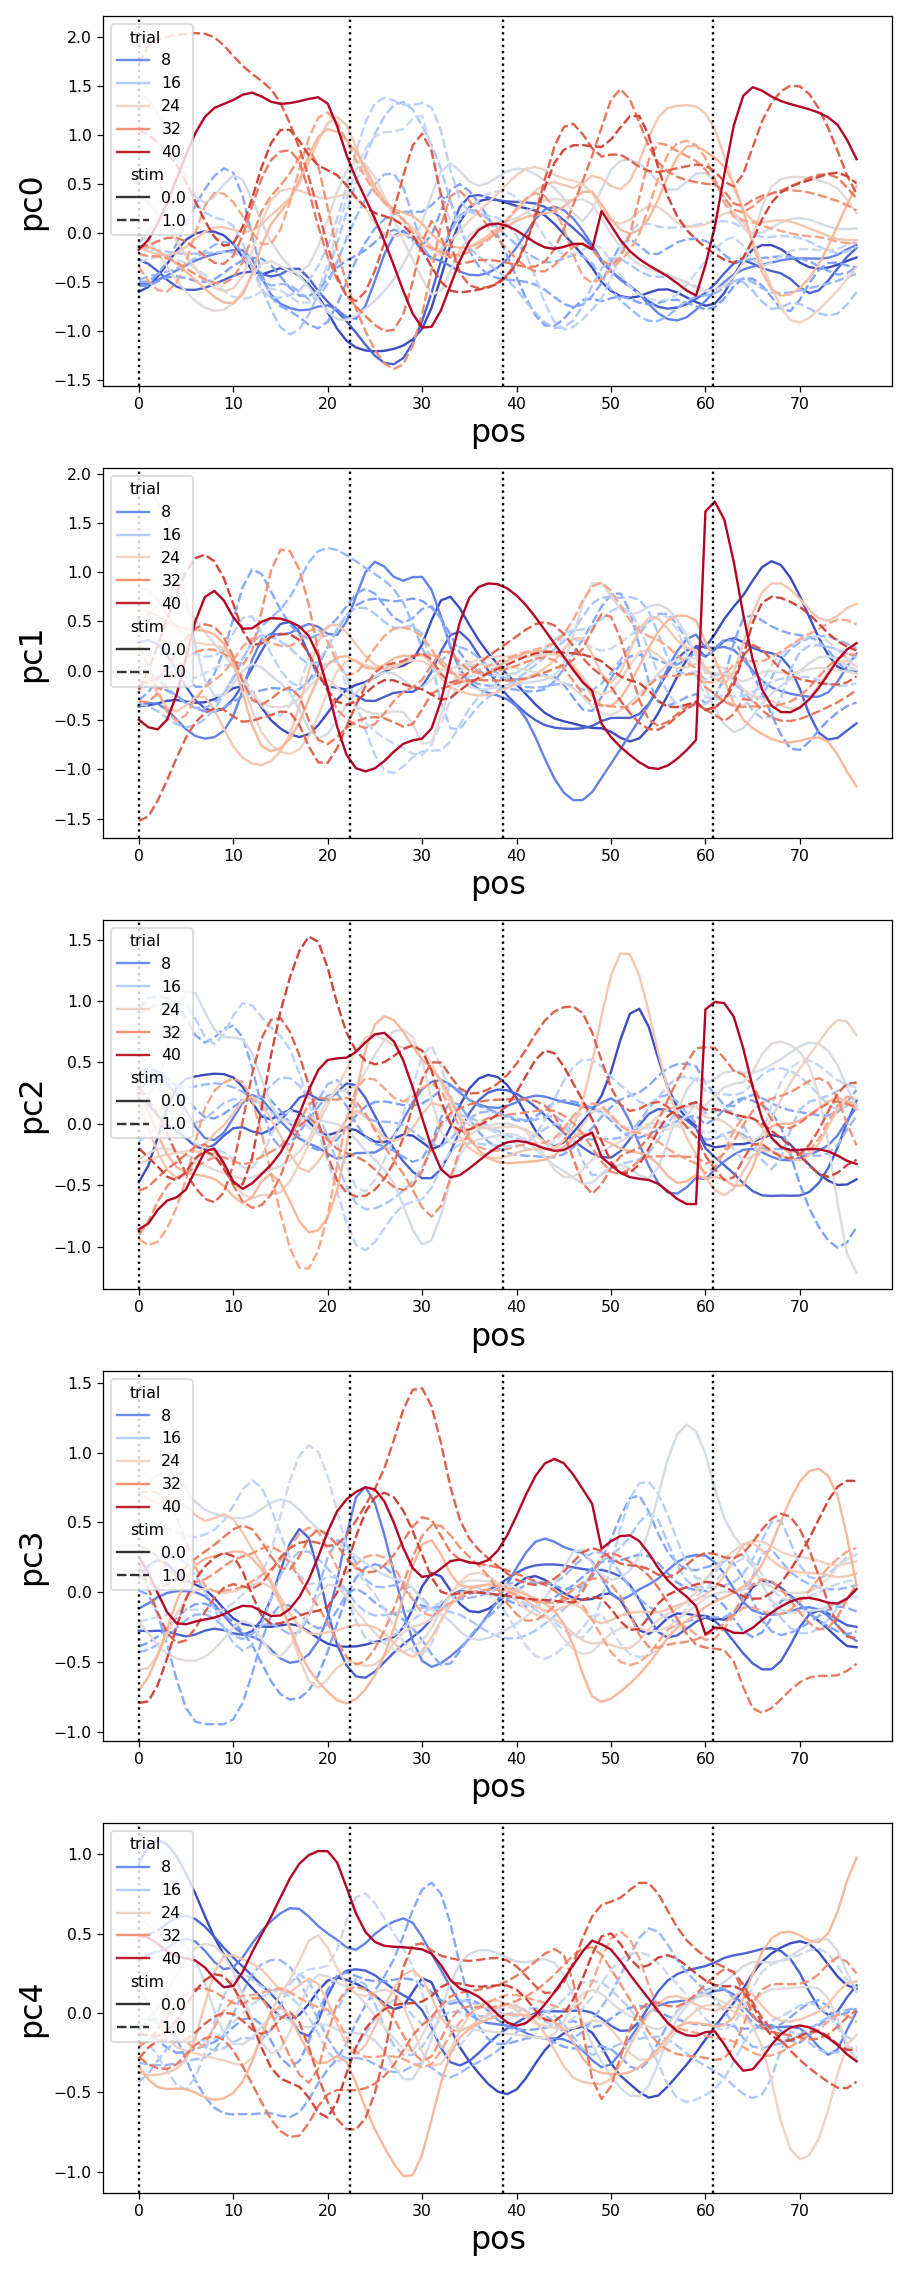

In [22]:
%matplotlib notebook
# toplot = h_l_allfac_fit_df.query('trial<=33')
toplot = h_l_allfac_fit_df.query('visitedArm==@tt_ind')
# toplot = h_one_trial_df_l.query('25>=trial>=15')
n_fac = 5#h_l_allfac_fit.shape[1]
nplots = n_fac
fig,axs=plt.subplots(nplots,1,figsize=(1*8,nplots*4))
cols = h_l_allfac_fit_df.columns[:nplots]
for ii in range(n_fac):
#     sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='stim',palette='coolwarm',ax=axs[ii])
#     sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='random',palette='coolwarm',ax=axs[ii])
    sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='trial',style='stim',palette='coolwarm',ax=axs[ii])
    ph.plot_vlines(lin_val_left/binsize_in_lin,ax=axs[ii],fig=fig)
plt.tight_layout()

<IPython.core.display.Javascript object>


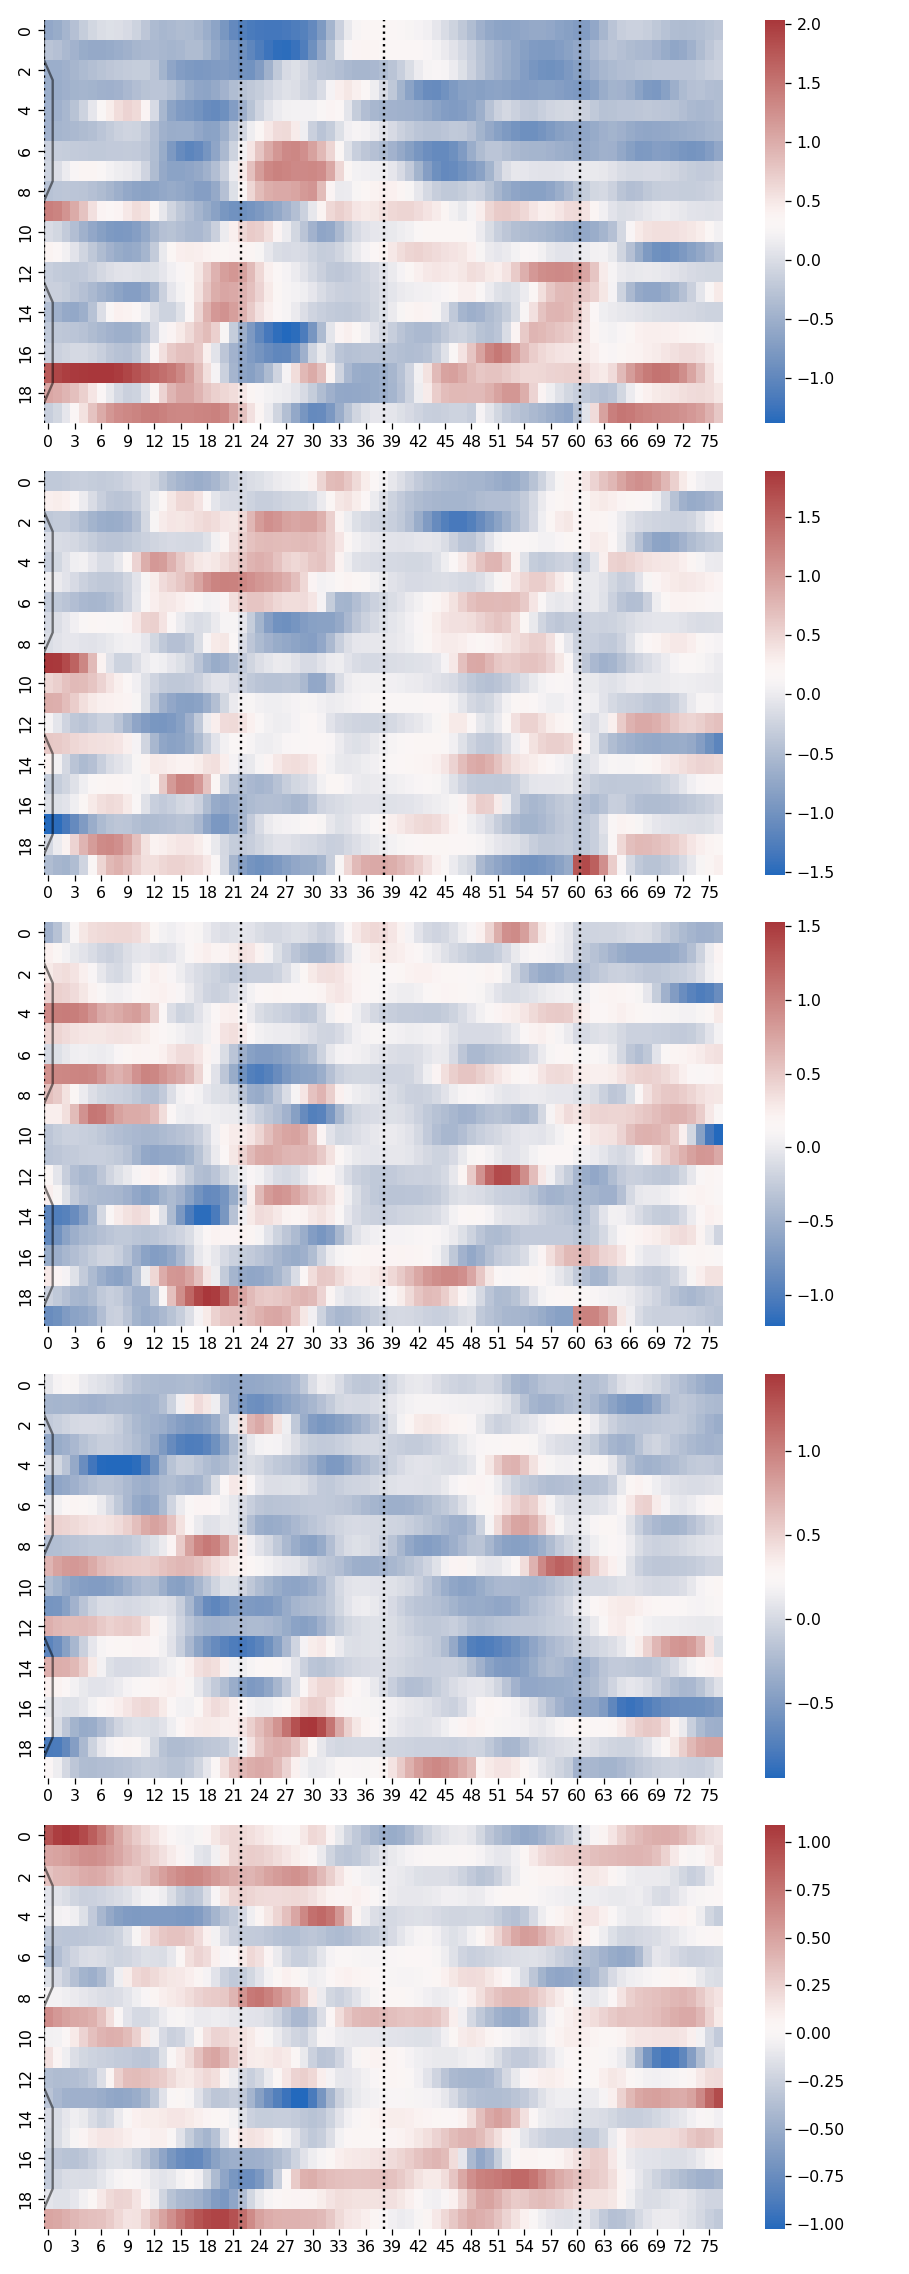

In [39]:
%matplotlib notebook
# toplot = h_l_allfac_fit_df.query('trial<=33')
toplot = h_l_allfac_fit_df.query('visitedArm==@tt_ind')
# toplot = h_one_trial_df_l.query('25>=trial>=15')
n_fac = 5#h_l_allfac_fit.shape[1]
nplots = n_fac
fig,axs=plt.subplots(nplots,1,figsize=(1*8,nplots*4))
cols = h_l_allfac_fit_df.columns[:nplots]
for ii in range(n_fac):
#     sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='stim',palette='coolwarm',ax=axs[ii])
#     sns.lineplot(data=toplot,x='pos',y=f'pc{ii}',hue='random',palette='coolwarm',ax=axs[ii])
    ax=sns.heatmap(h_l_allfac_fit_highlam[:,ii,:].T,cmap='vlag',ax=axs[ii])
    ax.plot(stim_per_trial_actual.values,np.arange(len(stim_per_trial_actual)),c='k',alpha=0.5)
    ph.plot_vlines(lin_val_left/binsize_in_lin,ax=axs[ii],fig=fig)
plt.tight_layout()

In [ ]:
ax=sns.heatmap(h_l_allfac_fit_highlam[:,0,:].T,cmap='vlag')


In [220]:
data=toplot.query('trial<=1')[['pos','pc0','pc1']].values.T

In [249]:
toplot.query('trial==21')

pos       pc0       pc1       pc2       pc3       pc4  trial  stim  \
847   0.0  1.846151 -0.014609 -0.724977 -0.697448 -0.115661     21   0.0   
848   1.0  1.903467  0.164398 -0.590138 -0.620418 -0.133131     21   0.0   
849   2.0  1.780686  0.194669 -0.406398 -0.563852 -0.106170     21   0.0   
850   3.0  1.546235  0.136694 -0.236427 -0.416624 -0.121541     21   0.0   
851   4.0  1.181470  0.043558 -0.108444 -0.135827 -0.219510     21   0.0   
..    ...       ...       ...       ...       ...       ...    ...   ...   
919  72.0  0.988928 -0.593770  0.008661  0.046011 -0.291186     21   0.0   
920  73.0  0.904063 -0.639312  0.096492  0.026286 -0.376041     21   0.0   
921  74.0  0.818515 -0.603173  0.224147  0.029680 -0.396041     21   0.0   
922  75.0  0.752828 -0.480981  0.391528  0.058529 -0.320680     21   0.0   
923  76.0  0.692658 -0.340389  0.526601  0.061215 -0.200565     21   0.0   

     visitedArm  random  
847         0.0       0  
848         0.0       0  
849         0.0       0  
850         0.0       0  
851         0.0       0  
..          ...     ...  
919         0.0       0  
920         0.0       0  
921         0.0       0  
922         0.0       0  
923         0.0       0  

[77 rows x 10 columns]

<IPython.core.display.Javascript object>


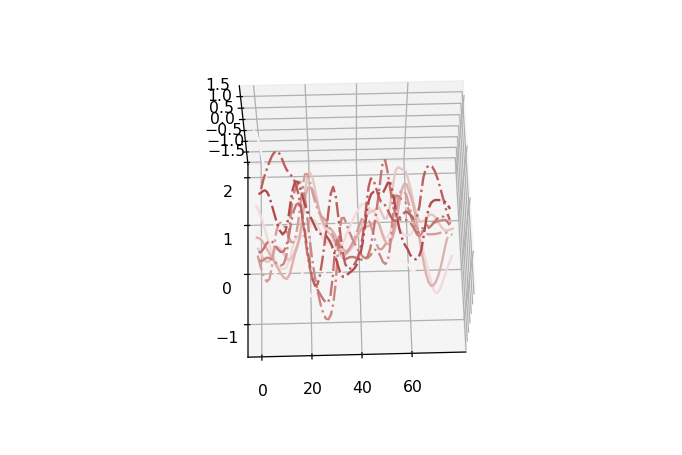

In [21]:
fig =plt.figure()
ax=fig.add_subplot(projection='3d')
linestyle_d = {0:'-',1:'-.'}
for tt in range(20,40):
#     try:
    toplot_sub = toplot.query('trial==@tt')
    data = toplot_sub[['pos','pc0','pc1']].values.T
    if toplot_sub.shape[0]>0:
        stim = toplot_sub['stim'].unique()[0]
        ax.plot(data[0],data[1],data[2],color=color_l_series.loc[tt],linestyle=linestyle_d[stim])
    

In [267]:
scipy.stats.pearsonr(h_l_allfac_fit_highlam[:,2,:].flatten(),h_l_allfac_fit_highlam[:,1,:].flatten())

(-0.0016085250290363453, 0.9472542483226742)

In [261]:
h_l_allfac_fit_highlam.mean(axis=1).mean(axis=-1)

array([-0., -0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
        0., -0., -0., -0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0., -0.,
       -0., -0., -0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0.,
       -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0.,  0.,
       -0.,  0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.])

<IPython.core.display.Javascript object>


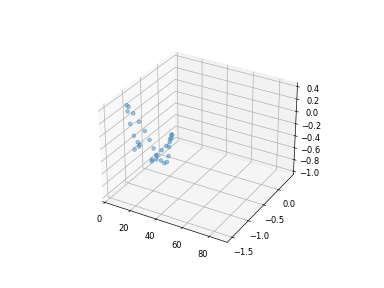

(<Figure size 640x480 with 1 Axes>,
 <Axes3DSubplot:>,
 <matplotlib.animation.FuncAnimation at 0x1554c444afa0>)

In [221]:

ah.animate_3d_scatter(data,legend_handles=None,color_l=None,marker_l=None,fig=None,ax=None,ax_kws={},animate_kws={'interval':100},dosave=False)




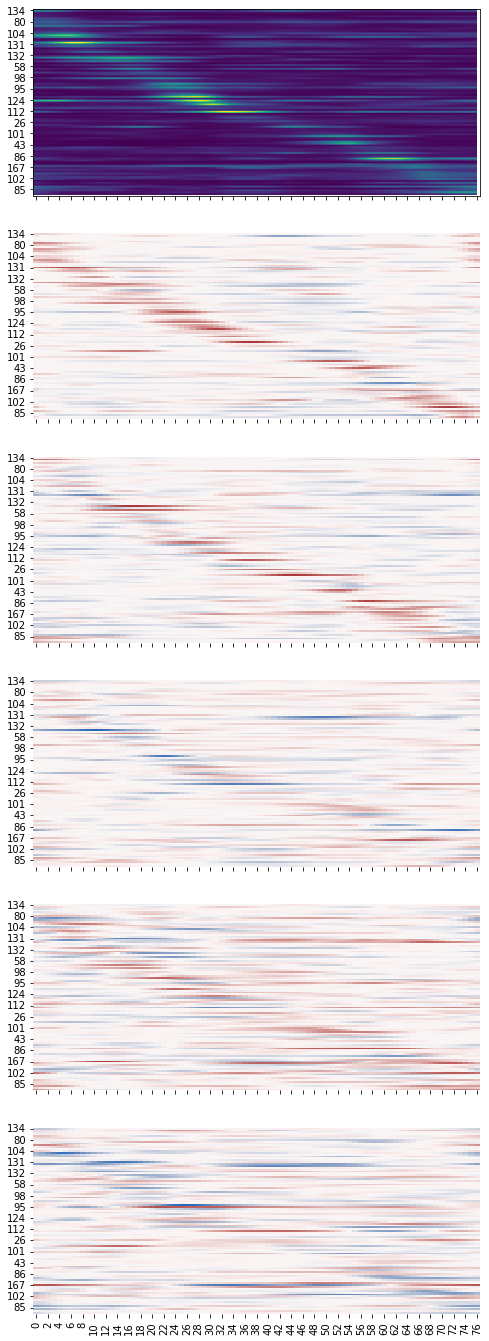

In [200]:
# visualize the PCs

import plot_ratemap_sequence as prs

%matplotlib inline
nfac = w_l_allfac_fit_highlam.shape[-1]
fig,axs = plt.subplots(nfac+1,1,sharex=True,sharey=True,figsize=(1*8,(nfac+1)*4))
fr_map_one= fr_map_trial_df_d.loc[task_ind,tt_ind].mean(axis=1).unstack()
fig,ax,order=prs.plot_population_sequence(fr_map_one,normalize=False,fig=fig,ax=axs[0])
for ii in range(w_l_allfac_fit_highlam.shape[-1]):
    w_one = w_l_allfac_fit_highlam[:,:,ii].T
    w_one_df=pd.DataFrame(w_one,index=fr_map_one.index)
    sns.heatmap(data=w_one_df.loc[order],cmap='vlag',center=0,ax=axs[ii+1],cbar=False)

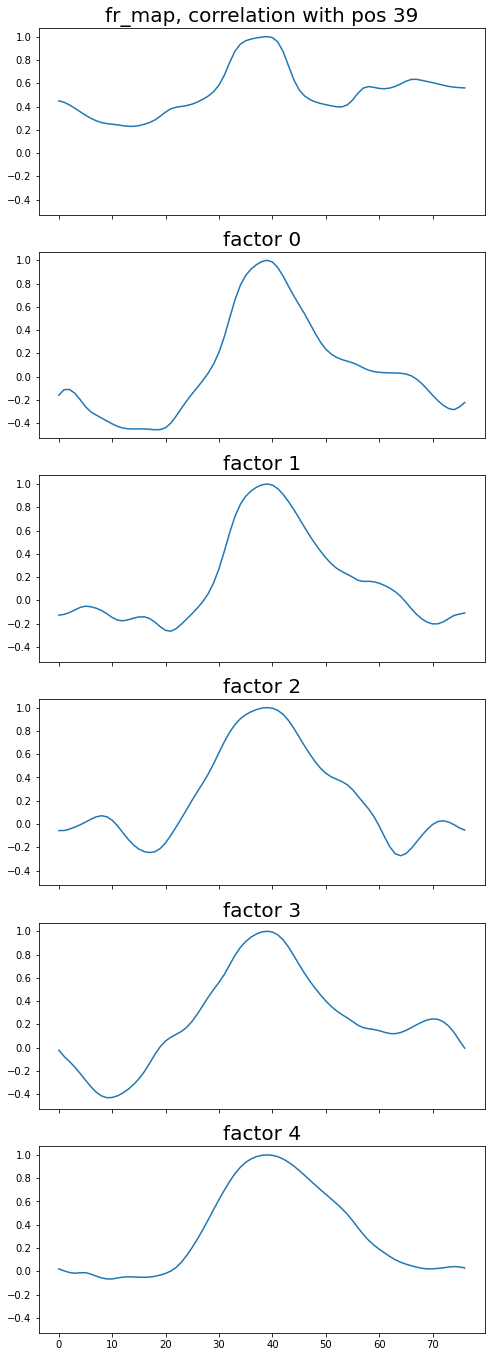

In [201]:
nfac = w_l_allfac_fit_highlam.shape[-1]
fig,axs = plt.subplots(nfac+1,1,sharex=True,sharey=True,figsize=(1*8,(nfac+1)*4))
fr_map_one= fr_map_trial_df_d.loc[task_ind,tt_ind].mean(axis=1).unstack()
ref_pos = 39
spatial_autocorr_frmap = fr_map_one.corr().loc[ref_pos]
axs[0].plot(spatial_autocorr_frmap)
axs[0].set_title(f'fr_map, correlation with pos {ref_pos}')
for ii in range(w_l_allfac_fit_highlam.shape[-1]):
    w_one = w_l_allfac_fit_highlam[:,:,ii].T
    w_one_df=pd.DataFrame(w_one,index=fr_map_one.index)
    spatial_autocorr_w_one = w_one_df.corr().loc[ref_pos]
#     sns.heatmap(data=w_one_df.loc[order],cmap='vlag',center=0,ax=axs[ii+1],cbar=False)
    axs[ii+1].plot(spatial_autocorr_w_one)
    axs[ii+1].set_title(f'factor {ii}')

<IPython.core.display.Javascript object>


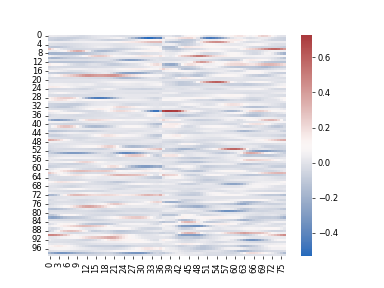

<AxesSubplot:>

In [114]:
fig,ax=plt.subplots()
sns.heatmap(data=pd.DataFrame(w_l_allfac_fit_highlam[:,:,0].T),cmap='vlag')

# firing rate vs stim-nonstim similarity

In [11]:
def get_fr_sim_corr(spk_beh_df,cell_cols,fr_key='fr_log',do_plot=False,**kwargs):
    _,spk_beh_df=dpp.group_into_trialtype(spk_beh_df,additional_groupers=['stim'])
    fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,**kwargs)
    fr_map_d_concat = pd.concat(fr_map_d)
    self_sim_d = pa.get_self_similarity_across_stim(fr_map_d_concat)
    mean_fr_per_cond = fr_map_d_concat.groupby(level=(0,1,3)).mean().mean(axis=1)
    self_sim_d_flat = self_sim_d.stack(level=(0,1)).unstack(level=0).stack(level=-1)
    sim_and_fr =pd.concat([self_sim_d_flat,mean_fr_per_cond],axis=1)
    sim_and_fr.columns=['sim','fr']
    sim_and_fr['fr_log'] = np.log(sim_and_fr['fr'])
    ma = sim_and_fr[['fr_log','sim']].notna().all(axis=1)
#     pdb.set_trace()
    if do_plot:
        g=sns.regplot(data=sim_and_fr,x=fr_key,y='sim')
    corr = scipy.stats.pearsonr(sim_and_fr.loc[ma,fr_key],sim_and_fr.loc[ma,'sim'])
    return corr



In [158]:
cell_cols_int = cell_cols_d['CA1','int']
fr_map_d_int,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_int,nbins=nbins,speed_key='speed',speed_thresh=1)
fr_map_d_concat_int = pd.concat(fr_map_d_int)
self_sim_d_int = pa.get_self_similarity_across_stim(fr_map_d_concat_int)
mean_fr_per_cond_int = fr_map_d_concat_int.groupby(level=(0,1,3)).mean().mean(axis=1)

<AxesSubplot:xlabel='None-None'>

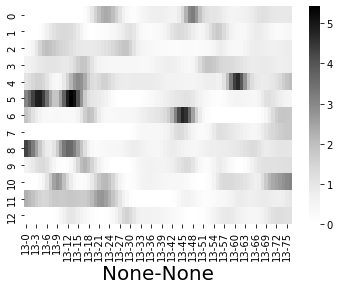

In [174]:
sns.heatmap(fr_map_trial_df_d.loc[0,0].loc[(slice(None),13),:].loc[0].T,cmap='Greys')

In [160]:
mean_fr_per_cond_int.loc[0,0]

4      30.604873
8      21.370875
12      3.664407
13      0.701826
20      7.056228
25      1.908110
27     17.413741
28      4.812888
29     16.030102
38     22.155722
42      0.479082
45      2.719768
47      2.938883
53     25.491910
69      2.453186
74      2.192533
76      0.801069
93      0.649798
100     0.048721
109     1.182803
120     0.410652
122     0.500818
125     2.381944
130     0.150720
133     0.353910
142     2.486883
143     4.801877
147     0.642234
151     4.005489
153     5.552794
156     0.570542
157     1.840205
159     7.248070
160     4.521910
162     3.839520
166     3.033505
170     1.685537
171     0.472086
174     0.136415
178     1.108014
dtype: float64

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-0.01907874635085434, 0.8125270239646677)

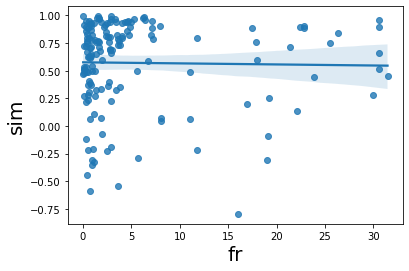

In [156]:
get_fr_sim_corr(spk_beh_df,cell_cols_d['CA1','int'],fr_key='fr',do_plot=True,nbins=nbins,speed_key='speed',speed_thresh=1)

(0.3281980730099563, 1.6878413671164703e-11)

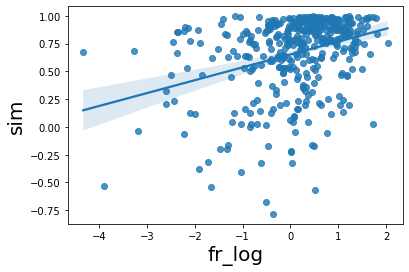

In [146]:
get_fr_sim_corr(spk_beh_df,cell_cols,do_plot=True,nbins=nbins,speed_key='speed',speed_thresh=1)

In [12]:
all_corr = fr_map_d_concat.T.corr()

In [13]:
reload(pa)
self_sim_d = pa.get_self_similarity_across_stim(fr_map_d_concat)

In [14]:
np.set_printoptions(precision=3,suppress=True)
task_ind,tt_ind = 0,0

self_similarity = self_sim_d[task_ind,tt_ind]

self_similarity = self_similarity.sort_values()

In [125]:
binsize_in_lin=spk_beh_df['lin'].max()/fr_map_d_concat.shape[1]

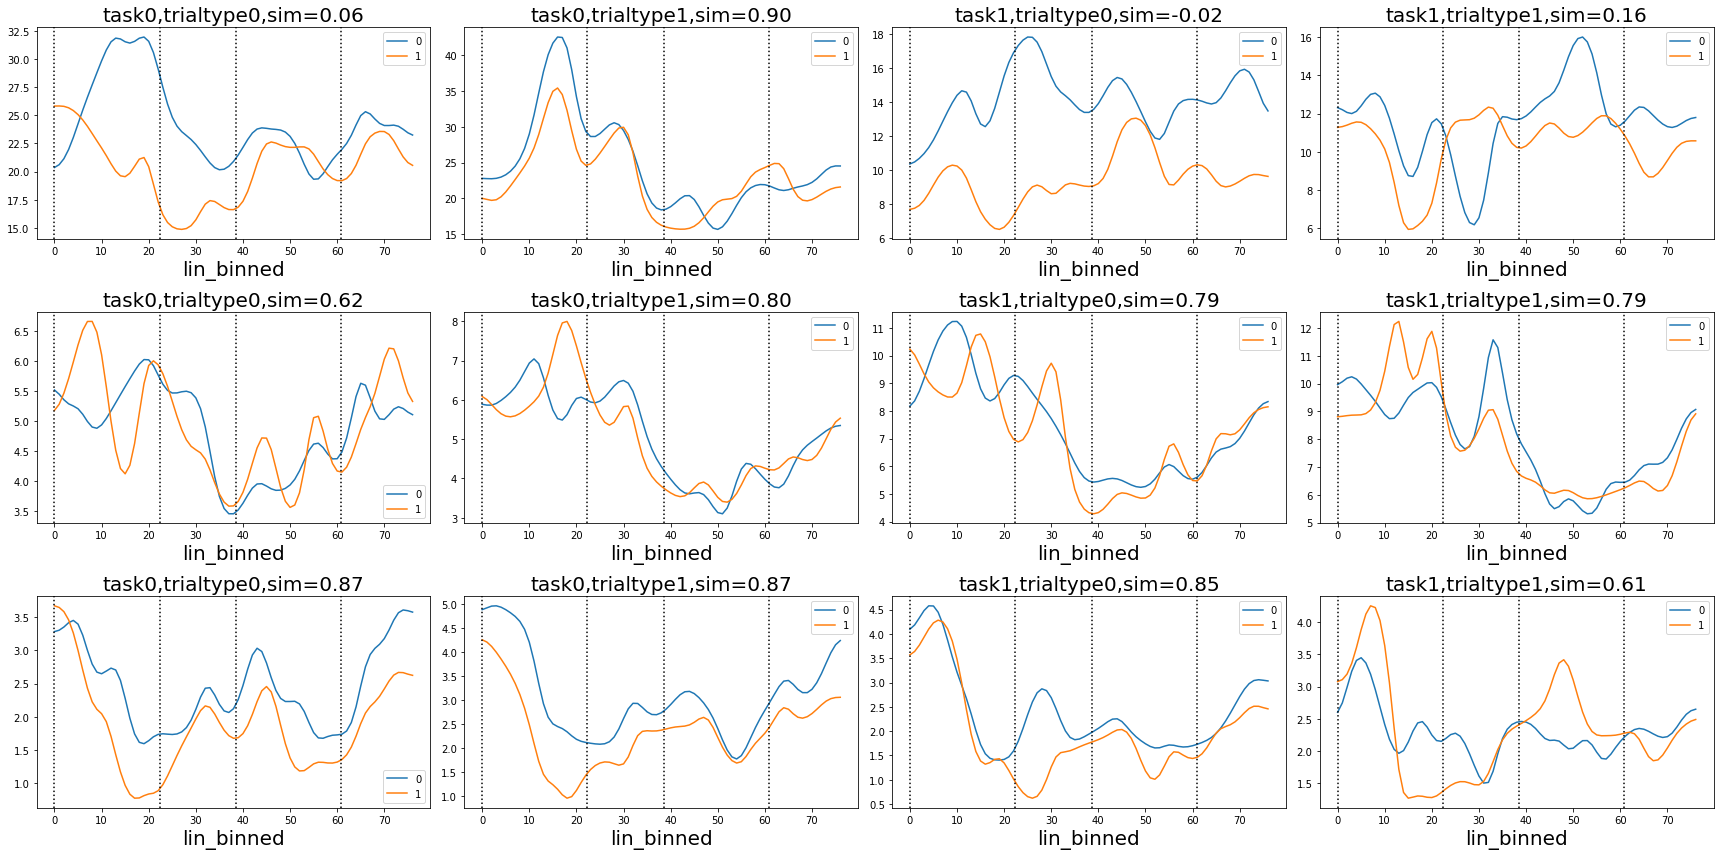

In [135]:
%matplotlib inline
nn=5
low_ind = self_similarity.index[nn]
mid_ind = self_similarity.index[len(self_similarity)//3 * 1 + nn]
high_ind = self_similarity.index[-(nn+1)]

ind_l = [low_ind,mid_ind,high_ind]
fig,axs = plt.subplots(3,len(self_sim_d.columns),figsize=(6*4,4*3))
for jj,kk in enumerate(self_sim_d.columns): 
    task_ind,tt_ind = kk
    for ii,ind in enumerate(ind_l):
        fr_map_d_concat.loc[task_ind,tt_ind,0,ind].plot(ax=axs[ii,jj])
        fr_map_d_concat.loc[task_ind,tt_ind,1,ind].plot(ax=axs[ii,jj])
        axs[ii,jj].set_title(f'task{kk[0]},trialtype{kk[1]:.0f},sim={self_sim_d.loc[ind,(task_ind,tt_ind)]:.02f}')
        axs[ii,jj].legend([0,1])
        plot_vlines(lin_val_left/binsize_in_lin,fig=fig,ax=axs[ii,jj])
plt.tight_layout()


In [19]:
def kde_findpeak(x,n_x = 80,**kwargs):
    x_range = np.linspace(np.min(x),np.max(x),n_x)
    kernel = scipy.stats.gaussian_kde(x)
    pdf = kernel(x_range)
    pdf_peaks = x_range[scipy.signal.find_peaks(pdf,height=0.015,**kwargs)[0]]
    return pdf_peaks,pdf
    

def find_t_maze_stoppoints_lin(xy,lin,radius=0.5,split_on_y=True):
    '''
    find the lin corresponding to corners/turns in t-maze, assuming those are where the animals spend more times 
    (mode in the distribution)
    
    find modes in kde of x and y positions, draw a small ball and average the corresponding lins. 
    special case: home cage will be ambiguous whether it's 0 or end, make it 0.
    
    
    xy: T x 2
    lin: T,
    split_on_y: y coordinate split into left and right turn
    radius: only for xy within this radius, consider the corresponding lin for the weighted average
    '''
    
    x_peaks,_ = kde_findpeak(xy[:,0])
    y_peaks,_ = kde_findpeak(xy[:,1])
    lin_d ={}
    for xp in x_peaks:
        for yp in y_peaks:
            dist = np.sqrt(np.sum((xy - np.array([[xp,yp]]))**2,axis=1)) + 1e-10
            ma =  dist <= radius 
            counts,edges=np.histogram(lin[ma])
            if (edges[-1]-edges[0]) > 1/2 * (np.max(lin)-np.min(lin)): # detect 0, which can be confused with the end
                lin_p = 0.
            else:
                lin_p = np.sum((lin[ma] * (1/dist[ma])) / (np.sum(1/dist[ma])))


            lin_d[(xp,yp)]=lin_p
    # reduce the lin values to avoid left right duplicates
    lin_val = np.array(list(lin_d.values()))
    lin_val_left = []
    for v in lin_val:
        ma = np.abs(v - lin_val) < 5.
        if ma.sum()>0:
            lin_val_left.append(np.mean(lin_val[ma]))
            lin_val = lin_val[~ma]
    lin_val_left = np.array(lin_val_left)
        
            
    return lin_d,lin_val_left

# def plot_vlines(lin_val_left,fig=None,ax=None):
#     if ax is None:
#         fig,ax= plt.subplots()
#     for l in lin_val_left:
#         ax.axvline(l,color='k',linestyle=':')
#     return fig,ax
    

In [20]:
lin_d,lin_val_left = find_t_maze_stoppoints_lin(spk_beh_df[['x','y']].values,spk_beh_df['lin'].values,radius=0.5,split_on_y=True)
binsize_in_lin=spk_beh_df['lin'].max()/fr_map_d_concat.shape[1]


In [65]:
fr = spike_trains.get_info('freq')

In [72]:
scipy.stats.pearsonr(fr.loc[self_sim_d.index],self_sim_d.median(axis=1))

(0.307752910063268, 0.001840691485710975)

(0.3949093568441042, 2.220528130508717e-16)

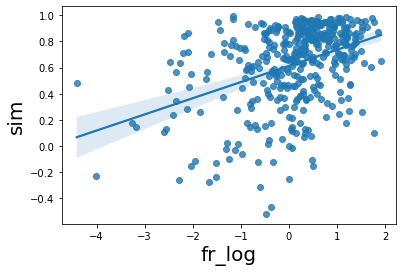

In [140]:
%matplotlib inline
mean_fr_per_cond = fr_map_d_concat.groupby(level=(0,1,3)).mean().mean(axis=1)


self_sim_d_flat = self_sim_d.stack(level=(0,1)).unstack(level=0).stack(level=-1)
sim_and_fr =pd.concat([self_sim_d_flat,mean_fr_per_cond],axis=1)
sim_and_fr.columns=['sim','fr']
sim_and_fr['fr_log'] = np.log(sim_and_fr['fr'])
g=sns.regplot(data=sim_and_fr,x='fr_log',y='sim')
scipy.stats.pearsonr(sim_and_fr['fr_log'],sim_and_fr['sim'])

In [104]:
import animate_helper as ah

<IPython.core.display.Javascript object>


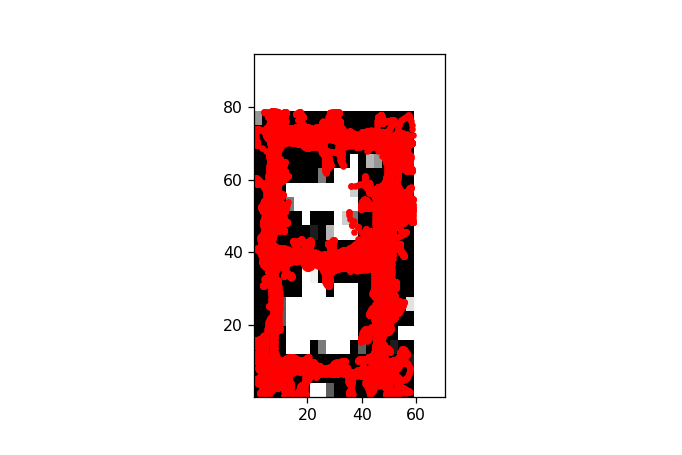

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.animation.FuncAnimation at 0x1554d2c400a0>)

In [122]:
%matplotlib notebook
reload(ah)
ah.animate_movement_in_maze(spk_beh_df[['x','y']].T.values,spk_beh_df['x'],spk_beh_df['y'],do_plot_background_maze=True)




In [49]:
# get field params!!!!!
reload(pa)
gpb = spk_beh_df.groupby('trial_type')
field_params_all = {}
fr_map_trial_all = {}
X_all = {}
X_all_norm = {}
fr_map_trial_df_all = {}
gauss_width = 2.5 * (170 / 222) # in ipshita's case, smaller maze
for key,val in gpb:
    fr_map_trial,count_trial,occu_trial = pa.get_fr_map_trial_onegroup(val,cell_cols,gauss_width=gauss_width,order=['smooth','divide'],n_lin_bins=100,speed_thresh=1)
    fr_map_trial_df = pf.fr_map_trial_to_df(fr_map_trial,cell_cols)
    fr_map_trial_df_all[key] = fr_map_trial_df
    field_params_trial=pf.get_field_params_trial(fr_map_trial_df,field_res_d[key]['all_fields'])
    fr_map_trial_all[key] = fr_map_trial_df
    field_params_all[key]=field_params_trial
    X_all[key] = field_params_trial.loc['fr']
    
    X_all_norm[key] = X_all[key] / X_all[key].max(axis=1).values[:,None]
    

cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [13]:
import ruptures as rpt


from pandarallel import pandarallel

In [ ]:
fn = '/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/switch_analysis/switch_res.p'
res_to_save_data = pickle.load(open(fn,'rb'))

X_to_be_analyzed = res_to_save_data['X']

In [130]:
%%time

pen_l = [0.1,0.3,0.6]
X_norm_pwc_d_allpen = {}
min_size = 1
for pen in pen_l:
    X_norm_pwc_d = {}
    for k,X in X_all.items():
        %time X_norm_pwc,cpts = cpa.predict_from_cpts_wrapper_allrows(X,pen,min_size=min_size)
        X_norm_pwc_d[k] = X_norm_pwc
    X_norm_pwc_d_allpen[pen] = X_norm_pwc_d
X_to_be_analyzed = {'raw':X_all_norm}
X_to_be_analyzed.update(X_norm_pwc_d_allpen)

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 111 ms, sys: 582 ms, total: 692 ms
Wall time: 1.24 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 86.3 ms, sys: 597 ms, total: 683 ms
Wall time: 1.06 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 83 ms, sys: 551 ms, total: 634 ms
Wall time: 1.08 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 79.9 ms, sys: 563 ms, total: 643 ms
Wall time: 1.05 s
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU time

<AxesSubplot:ylabel='None-None'>

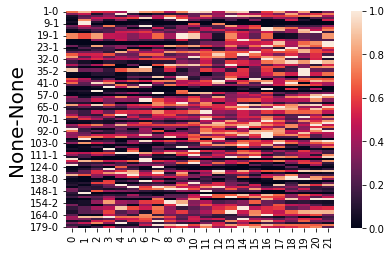

In [140]:
sns.heatmap(X_to_be_analyzed['raw'][0,0])

<AxesSubplot:ylabel='None-None'>

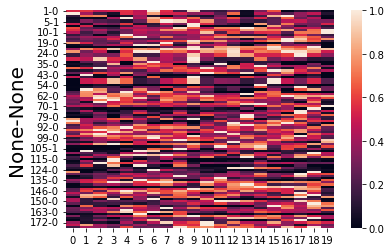

In [141]:
sns.heatmap(X_to_be_analyzed['raw'][0,1])

In [17]:
def trial_index_to_index_within_trialtype(spk_beh_df):
    '''
    {key:map_series}
    map_series: series: index: trial_index; val: index_within_trialtype
    '''
    trial_index_by_trialtype = spk_beh_df.groupby('trial_type')['trial'].unique()
    trial_index_to_index_within_trialtype_d = {}
    for key,val in trial_index_by_trialtype.iteritems():
        map_series = pd.Series(val)
        map_series = map_series.reset_index().set_index(0)['index']
        trial_index_to_index_within_trialtype_d[key] = map_series
    return trial_index_to_index_within_trialtype_d

In [18]:
trial_index_to_index_within_trialtype_d = trial_index_to_index_within_trialtype(spk_beh_df)

In [19]:
vars_index_within_trialtype_d = {}
var_key= 'stim'
for (tt), val in spk_beh_df.groupby(['trial_type']):
    gpb = val.groupby('trial')
    var_per_trial = gpb[var_key].mean().to_frame()
    var_per_trial['index_within_trialtype'] = trial_index_to_index_within_trialtype_d[tt].loc[var_per_trial.index]

    vars_index_within_trialtype_d[tt] = var_per_trial
#         trial_index_to_index_within_trialtype_d[tt].loc[tr]
vars_index_within_trialtype_df = pd.concat(vars_index_within_trialtype_d)

In [20]:
vars_index_within_trialtype_df.loc[0,0]

stim  index_within_trialtype
trial                              
0       0.0                       0
1       0.0                       1
3       0.0                       2
5       0.0                       3
6       0.0                       4
8       0.0                       5
9       0.0                       6
12      1.0                       7
14      1.0                       8
16      1.0                       9
18      1.0                      10
21      0.0                      11
23      0.0                      12
25      0.0                      13
27      0.0                      14
29      0.0                      15
31      1.0                      16
33      1.0                      17
35      1.0                      18
37      1.0                      19
39      1.0                      20
40      0.0                      21

In [ ]:
%%time
plt.ioff()
tosweep_key_l = ['switch_magnitude','high_thresh']
tosweep_val_l = [np.arange(0,0.7,0.1).round(1),np.arange(0.3,0.8,0.1).round(1)]
kwargs_l = [dict(low_thresh=1,high_thresh=0),
    dict(low_thresh=0.2,switch_magnitude = 0),
]
cdf_alltrialtype,sig_alltrialtype,sr_alltrialtype,changes_df_alltrialtype,fig_alltrialtype = cpa.sweep_test_switch_ratio_multisweep_alltrialtype_multipreprocess(X_to_be_analyzed,min_size,tosweep_key_l,tosweep_val_l,kwargs_l,detect_func=cpa.detect_switch_pwc,alpha=0.05,do_bonf=True,doplots=True,nrepeats=1000)    

res_to_save_data = dict(
    X = X_to_be_analyzed,
    cdf=cdf_alltrialtype,
    sig=sig_alltrialtype,
    sr=sr_alltrialtype,
    changes_df=changes_df_alltrialtype,
    fig=fig_alltrialtype
)

In [143]:
res_to_save_dir = os.path.join(data_dir_full,'py_data','switch_analysis')
if not os.path.exists(res_to_save_dir):
    os.makedirs(res_to_save_dir)
    print(f'{res_to_save_dir} made!',flush=True)

res_to_save_name = f'switch_res'
res_to_save_fn  = os.path.join(res_to_save_dir,res_to_save_name+'.p')

pickle.dump(res_to_save_data,open(res_to_save_fn,'wb'))
print(f'{res_to_save_fn} saved!', flush=True)

/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/switch_analysis made!
/mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210312_sess8/py_data/switch_analysis/switch_res.p saved!


/tmp/ipykernel_280062/1814714888.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]


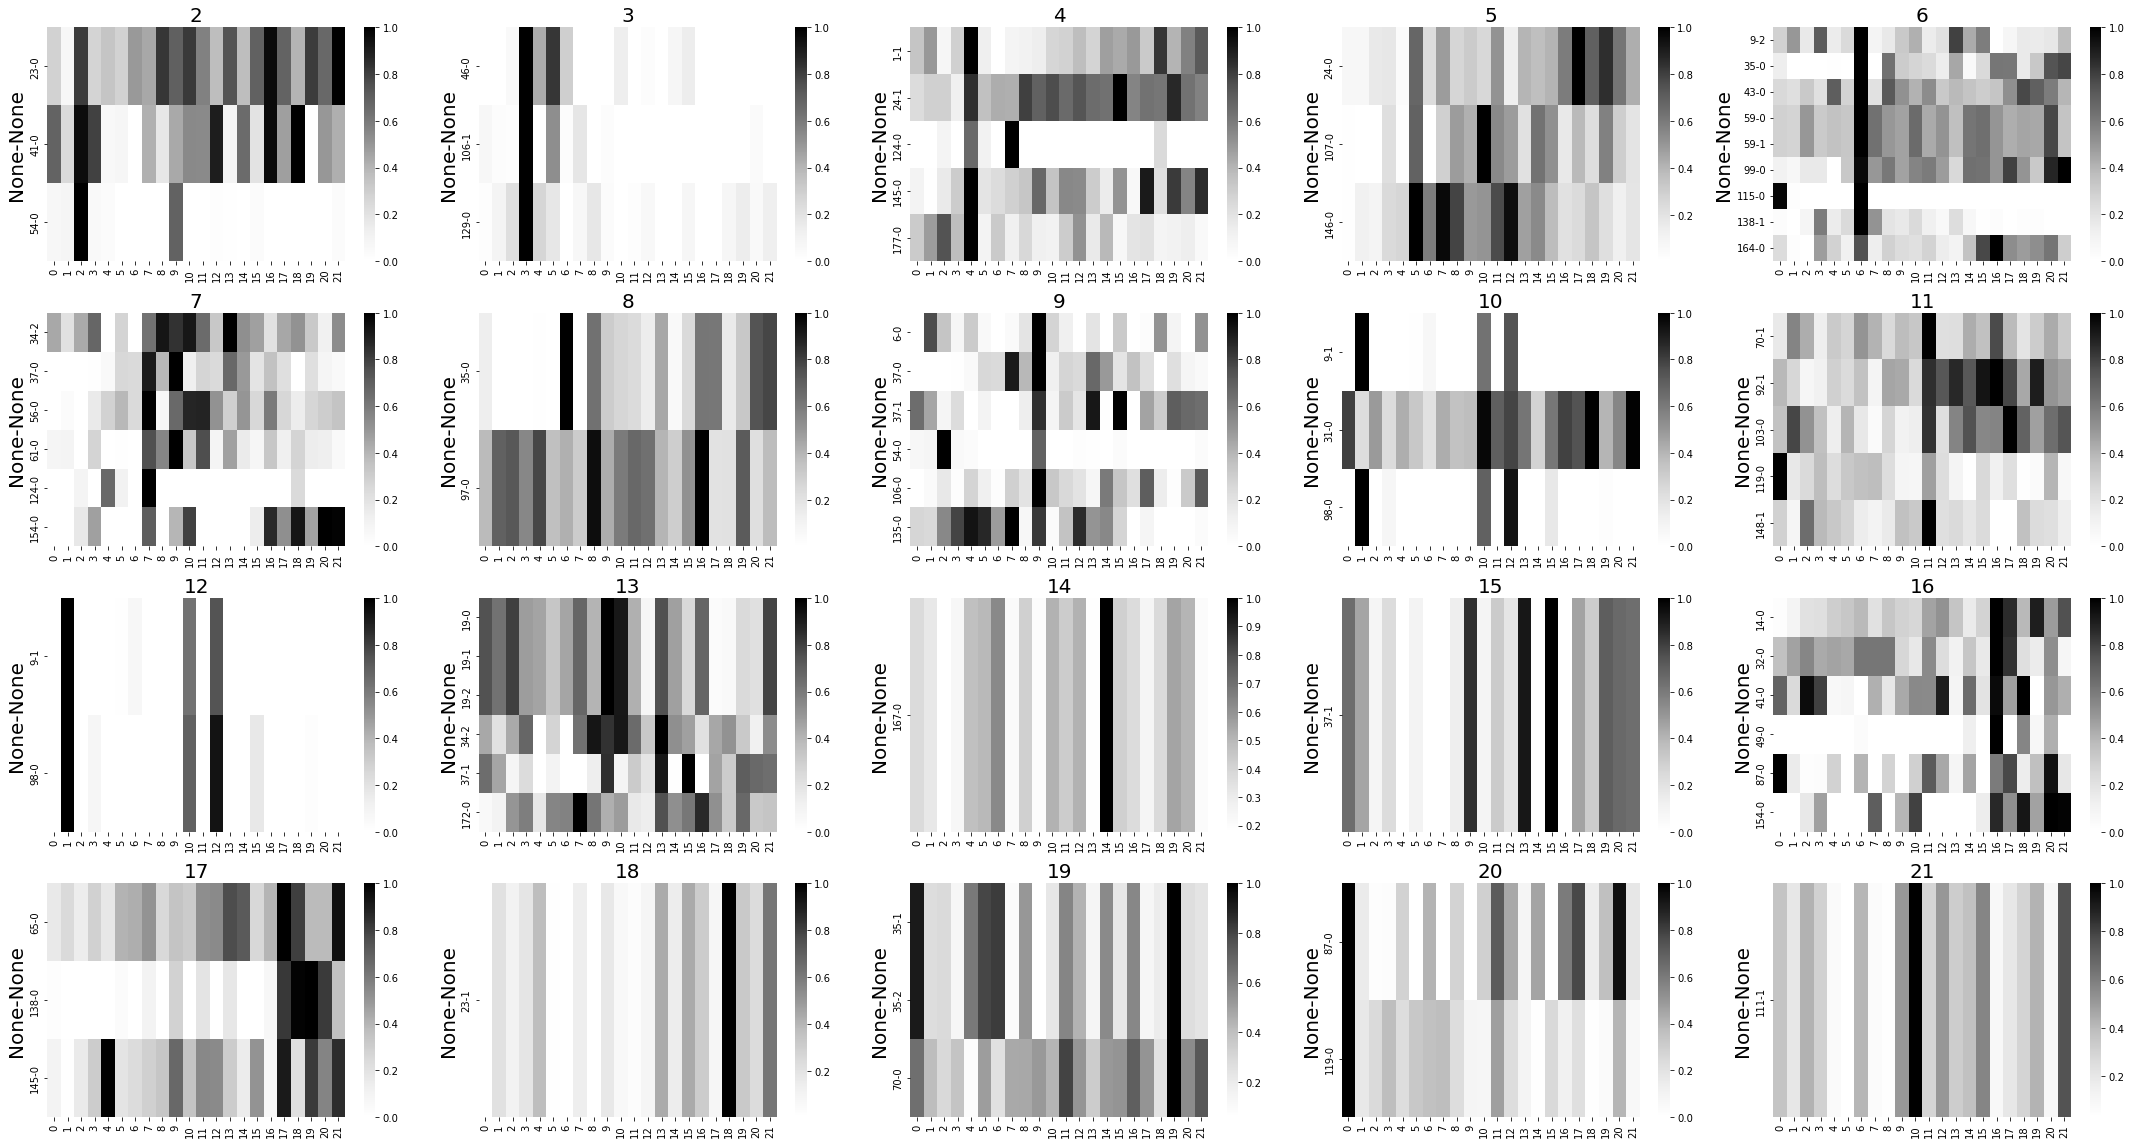

In [30]:
trialtype = (0,0)
pen = 'raw'
tosweep_key = 'switch_magnitude'
tosweep_val = 0.6
changes=res_to_save_data['changes_df'].loc[(*trialtype,pen,tosweep_key,tosweep_val),:]
inds_d = cpa.get_inds_switch_sametrial_sorted(changes)
fig,axs=cpp.plot_fields_switching_each_trial(X_to_be_analyzed['raw'][trialtype],inds_d.loc[1])

In [249]:
cell_cols_d['CA1','pyr']

array([  1,   2,   3,   5,   6,   7,  10,  11,  14,  18,  19,  21,  22,
        23,  24,  26,  31,  34,  36,  37,  39,  43,  44,  49,  51,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  68,  70,
        73,  75,  78,  79,  80,  82,  83,  84,  85,  86,  90,  91,  92,
        94,  95,  97,  98,  99, 101, 102, 103, 104, 105, 110, 111, 112,
       113, 116, 123, 124, 126, 128, 129, 131, 132, 134, 136, 137, 138,
       140, 141, 144, 145, 146, 148, 150, 152, 154, 155, 161, 163, 164,
       165, 167, 169, 172, 173, 175, 176, 177, 179], dtype=uint8)